In [20]:
#优化 进行预剪枝的决策树
def getData(filename):
    f = open(filename,'r')
    datas = f.readlines()
    label = datas[0].split(',')
    del (label[6])
    # label[len(label)-1] = label[len(label)-1].replace('\n','')
    data_set = []
    for i in range(1,len(datas)):
        temp = datas[i].split(',')
        temp[len(temp) - 1] = temp[len(temp) - 1].replace('\n', '')
        data_set.append(temp)
    return label,data_set

label_set,data_set = getData('data/car_data.csv')

print(label_set)
#加载训练数据 80% 测试数据 20%
train_list = data_set[0:1382]  # 训练集 数据
test_list = data_set[1383:]  # 测试集 数据
print('训练集大小',len(train_list))
print('测试集大小',len(test_list))

label_count = {'buying':4,'maint':4,'doors':4,'persons':3,'lug_boot':3,'safety':3}

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
训练集大小 1382
测试集大小 345


In [21]:
def training(features, targets):
    # 计算各类别的样本个数
    label_count = {}
    for classify in targets:
        if classify not in label_count.keys():
            label_count[classify] = 0
        label_count[classify] += 1
    print(label_count)

    k = len(label_count.keys())  # 类别数
    # feature 的 m行  n列
    m = len(features)
    n = len(features[0])

    # 计算先验概率  每一类出现的概率
    lamb = 1  # 平滑处理的参数  拉普拉斯修正
    prior = dict()  # 存储先验概率

    for label, amount in label_count.items():
        prior[label] = (amount + lamb) / (m + k * lamb)  # 计算平滑处理后的先验概率 拉普拉斯修正

    print(prior)

    conditional = dict()  # 存储条件概率
    for feature in range(n):  # 遍历每个特征
        conditional[feature] = {}
        values = []  # 存放 每一个特征有多少种取值
        for data in features:
            if data[feature] not in values:
                values.append(data[feature])
        for value in values:  # 遍历每个特征值
            conditional[feature][value] = {}  # 第i的特征的取值value
            for label, amount in label_count.items():  # 遍历每种类别
                # 截取该类别的数据集
                feature_label = []  # 存储类别为label的数据集
                for j in range(0, m):
                    if label == targets[j]:
                        feature_label.append(features[j])
                # 计算该类别下各特征值出现的次数
                c_label = {}  # 存放该类别下 每一个特征值出现的次数
                for data in feature_label:
                    if data[feature] not in c_label.keys():
                        c_label[data[feature]] = 0
                    c_label[data[feature]] += 1
                # 计算平滑处理后的条件概率  拉普拉斯修正
                conditional[feature][value][label] = (c_label.get(value, 0) + lamb) / \
                                                     (amount + len(values) * lamb)  # 计算平滑处理后的条件概率

    return prior, conditional

features = []  # 数据在每一纬度的特征   特征集m*n,m为样本数,n为特征数
target = []  # 数据的真实分类   标签集
for data in train_list:
    features.append(data[0:-1])
    target.append(data[-1])
prior, conditional = training(features, target)  # 计算 先验概率  条件概率


{'1': 303, '0': 977, '2': 51, '3': 51}
{'1': 0.21933621933621933, '0': 0.7056277056277056, '2': 0.03751803751803752, '3': 0.03751803751803752}


In [22]:
def predict(test, prior, conditional):
    """预测单个样本"""
    best_poster, best_label = -np.inf, -1
    for label in prior:
        # 初始化后验概率为先验概率,同时把连乘换成取对数相加，防止下溢（即太多小于1的数相乘，结果会变成0）
        poster = np.log(prior[label])
        for i in range(0, len(test)-1):
            # 第i个特征（第i列） 取值为test[i]  类别为label 的条件概率   由于取了对数 所以加变成了乘
            poster += np.log(conditional[i][test[i]][label])
        if poster > best_poster:  # 获取后验概率最大的类别
            best_poster = poster
            best_label = label
    return best_label


pos_count = 0  # 正确分类数量
neg_count = 0  # 错误分类数量
classify_result_list = []  # 存储分类结果
for test in test_list:
    classify_result = predict(test, prior, conditional)
    classify_result_list.append(classify_result)

for i in range(0, len(classify_result_list)):
    if classify_result_list[i] == test_list[i][6]:
        pos_count += 1
    else:
        neg_count += 1
print('测试集总数', len(test_list))
print('正确分类数', pos_count)
print('错误分类数', neg_count)
print('分类的准确率为', pos_count / len(test_list))

测试集总数 345
正确分类数 285
错误分类数 60
分类的准确率为 0.8260869565217391


对于结果为unacc  即数据集中classify 为0的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.7357142857142858
精度(查准率) ———— 0.6957928802588996
召回率(查全率)———— 0.7357142857142858
f1值 ———— 0.7948243992606284


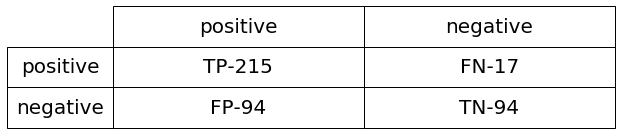

In [24]:
#对于结果为unacc  classify 为0  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为unacc  即数据集中classify 为0的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为0 且真实为0的数据   将一个正例正确判断为正例
#fp 为预测结果为0 且真实为1，2，3的数据    将一个反例错误判断为正例
#fn 为预测结果为1，2，3 且真实为0的数据     将一个正例错误判断为反例
#tn 为预测结果为1，2，3 且真实为1，2，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == '0' and  classify_result_list[i] == '0':
        tp += 1
    if test_list[i][6] == '0' and  classify_result_list[i] != '0':
        fn += 1
    if test_list[i][6] != '0' and  classify_result_list[i] != '0':
        fp += 1
    if test_list[i][6] != '0' and  classify_result_list[i] != '0':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
f1 = (2*precision*recall) / (precision+recall)
print('f1值 ————',f1)


            
            
       


对于结果为acc  即数据集中classify 为1的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.5384615384615384
精度(查准率) ———— 0.21254355400696864
召回率(查全率)———— 0.5384615384615384
f1值 ———— 0.3315217391304348


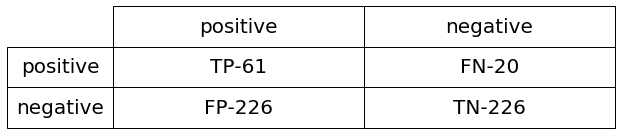

In [25]:
#对于结果为acc  classify 为1  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为acc  即数据集中classify 为1的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为1 且真实为1的数据   将一个正例正确判断为正例
#fp 为预测结果为1 且真实为0，2，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，2，3 且真实为1的数据     将一个正例错误判断为反例
#tn 为预测结果为0，2，3 且真实为0，2，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == '1' and  classify_result_list[i] == '1':
        tp += 1
    if test_list[i][6] == '1' and  classify_result_list[i] != '1':
        fn += 1
    if test_list[i][6] != '1' and  classify_result_list[i] != '1':
        fp += 1
    if test_list[i][6] != '1' and  classify_result_list[i] != '1':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
f1 = (2*precision*recall) / (precision+recall)
print('f1值 ————',f1)

对于结果为good  即数据集中classify 为2的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.49101796407185627
精度(查准率) ———— 0.009146341463414634
召回率(查全率)———— 0.49101796407185627
f1值 ———— 0.017341040462427744


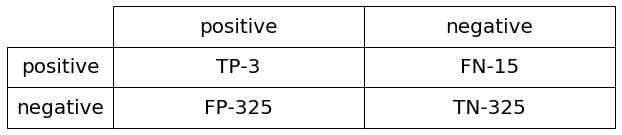

In [26]:
#对于结果为good  classify 为2  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为good  即数据集中classify 为2的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为2 且真实为2的数据   将一个正例正确判断为正例
#fp 为预测结果为2 且真实为0，1，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，1，3 且真实为2的数据     将一个正例错误判断为反例
#tn 为预测结果为0，1，3 且真实为0，1，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == '2' and  classify_result_list[i] == '2':
        tp += 1
    if test_list[i][6] == '2' and  classify_result_list[i] != '2':
        fn += 1
    if test_list[i][6] != '2' and  classify_result_list[i] != '2':
        fp += 1
    if test_list[i][6] != '2' and  classify_result_list[i] != '2':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
if 2*precision*recall == 0:
    print('f1值 ————',0.0)
else:
    f1 = (2*precision*recall) / (precision+recall)
    print('f1值 ————',f1)

对于结果为vgood  即数据集中classify 为3的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.49851632047477745
精度(查准率) ———— 0.017857142857142856
召回率(查全率)———— 0.49851632047477745
f1值 ———— 0.03428571428571428


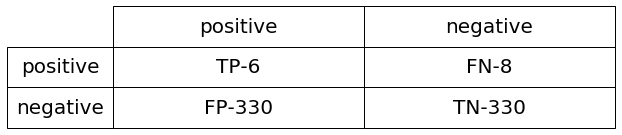

In [27]:
#对于结果为vgood  classify 为3  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为vgood  即数据集中classify 为3的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为2 且真实为2的数据   将一个正例正确判断为正例
#fp 为预测结果为2 且真实为0，1，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，1，3 且真实为2的数据     将一个正例错误判断为反例
#tn 为预测结果为0，1，3 且真实为0，1，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == '3' and  classify_result_list[i] == '3':
        tp += 1
    if test_list[i][6] == '3' and  classify_result_list[i] != '3':
        fn += 1
    if test_list[i][6] != '3' and  classify_result_list[i] != '3':
        fp += 1
    if test_list[i][6] != '3' and  classify_result_list[i] != '3':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值
if 2*precision*recall == 0:
    print('f1值 ————',0.0)
else:
    f1 = (2*precision*recall) / (precision+recall)
    print('f1值 ————',f1)